In [1]:
import sys
sys.path.append("..")
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
from LowLevelModules.GeneralFunctions import get_work_dir, prettify_plot, prettify_2d_plot
import numpy as np
from numpy import abs, exp, pi

def refrac_index(eps):
    eps_modulus = np.absolute(eps)
    n_real = np.sqrt((eps_modulus + np.real(eps))/2)
    n_imaginary = np.sqrt((eps_modulus - np.real(eps))/2)
    return n_real + 1j * n_imaginary

def refl_coeff(n_inc, n_target):
    return (n_inc - n_target) / (n_inc + n_target)

###################################   CONSTANTS   ####################################
n_vac = {532: 1, 637: 1}
n_hbn = {532: 2.2, 637: 2.2}
#n_si = 3.881 - .019j

# WSe2
# n_wse2 = 5 + 0.5j     # ref: https://onlinelibrary.wiley.com/doi/full/10.1002/adom.201900239                       
eps_wse2 = {532: 19 + 11j, 637: 20 + 3j}    # ref: https://journals.aps.org/prb/pdf/10.1103/PhysRevB.90.205422 
n_wse2 = {k: refrac_index(v) for k, v in eps_wse2.items()}

eps_gold = {532: -5 +2.5j, 637: -8 + 1j}
n_gold = {k: refrac_index(v) for k, v in eps_gold.items()}

r1 = {k1: refl_coeff(v1, v2) for (k1, v1), (k2, v2) in zip(n_vac.items(), n_hbn.items())}
r2 = {k1: refl_coeff(v1, v2) for (k1, v1), (k2, v2) in zip(n_hbn.items(), n_wse2.items())}
r3 = {k1: refl_coeff(v1, v2) for (k1, v1), (k2, v2) in zip(n_vac.items(), n_gold.items())}


########## PHASE ACQUIRED IN HBN OF THICKNESS t  AND HOLE DEPTH d   ###################
def Phi(t, n_i, wvl_key):
    wvl = wvl_key*1e-9
    return 2*pi*n_i[wvl_key]*t/wvl

################################# REFLECTANCE  ########################################
def R(t, d, wvl): 
    return abs(
        (
         r1[wvl]*exp(1j * (Phi(t, n_hbn, wvl) + Phi(d, n_vac, wvl))) + 
         r2[wvl]*exp(-1j * (Phi(t, n_hbn, wvl) - Phi(d, n_vac, wvl))) + 
         r3[wvl]*exp(-1j * (Phi(t, n_hbn, wvl) + Phi(d, n_vac, wvl))) + 
         r1[wvl]*r2[wvl]*r3[wvl]*exp(1j * (Phi(t, n_hbn, wvl) - Phi(d, n_vac, wvl)))
        )
            /
        (
         exp(1j * (Phi(t, n_hbn, wvl) + Phi(d, n_vac, wvl))) + 
         r1[wvl]*r2[wvl]*exp(-1j * (Phi(t, n_hbn, wvl) - Phi(d, n_vac, wvl))) + 
         r1[wvl]*r3[wvl]*exp(-1j * (Phi(t, n_hbn, wvl) + Phi(d, n_vac, wvl))) + 
         r2[wvl]*r3[wvl]*exp(1j * (Phi(t, n_hbn, wvl) - Phi(d, n_vac, wvl)))
        )
    )**2

<IPython.core.display.Javascript object>


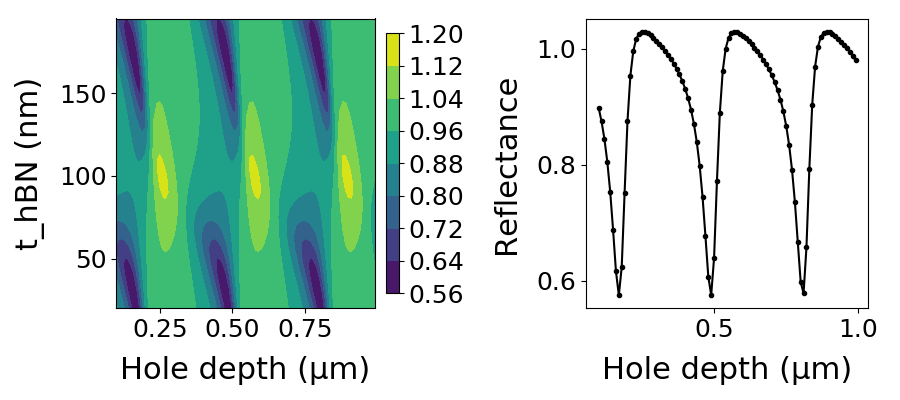

In [89]:
lambda_ = 637
# reflectance versus hole depth
z = np.arange(100, 1000, 10) * 1e-9
t_hbn = np.arange(20, 200, 5) * 1e-9
zz, tt = np.meshgrid(z, t_hbn)
reflect = R(tt, zz, lambda_)
fig1 = plt.figure(figsize=(9, 4))
ax1 = fig1.add_subplot(121)
ax2 = fig1.add_subplot(122)
cp1 = ax1.contourf(z*1e6, t_hbn*1e9, reflect)
cb1 = plt.colorbar(cp1, ax=ax1, fraction=0.046, pad=0.04)

# 1D plot for known trench depth
# z_nm = z * 1e9
# idx = np.where(z_nm.astype(int) == 250)[0][0]
# ax2.plot(t_hbn, reflect[:,idx])
reflect_1d = R(18e-9, z, lambda_)
ax2.plot(z*1e6, reflect_1d, 'k.-')
ax2.set_xlabel('Hole depth (μm)', labelpad=10, fontsize=22)
ax2.tick_params(axis='both', labelsize=18)
prettify_2d_plot(ax1, cb1, 'Hole depth (μm)', 't_hBN (nm)','Reflectance')
fig1.tight_layout()

<IPython.core.display.Javascript object>


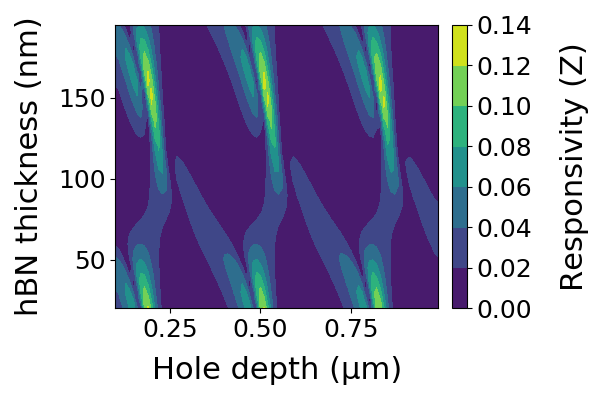

In [90]:
# displacement responsivity
disp = abs(np.gradient(reflect))[1]
fig2 = plt.figure(figsize=(6, 4))
ax3 = fig2.add_subplot(111)
cp3 = ax3.contourf(z*1e6, t_hbn*1e9, disp)
cb3 = plt.colorbar(cp3, ax=ax3, fraction=0.046, pad=0.04)


# fig = plt.figure(figsize=(6, 4))
prettify_2d_plot(ax3, cb3, 'Hole depth (μm)', 'hBN thickness (nm)','Responsivity (Z)')
fig2.tight_layout()

<IPython.core.display.Javascript object>


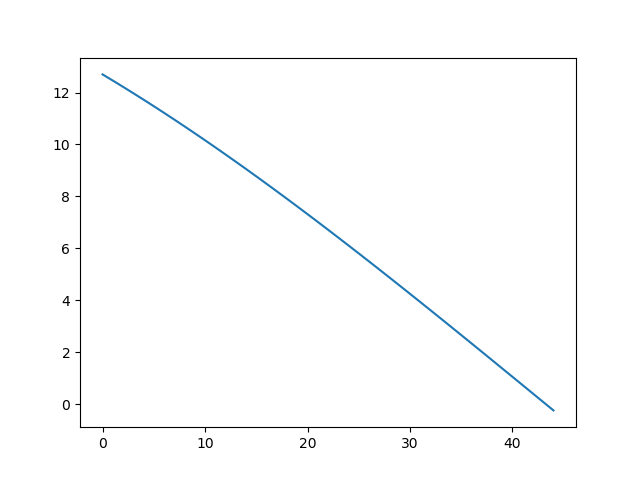

In [6]:
# calculate clearance of 1/2 inch filter versus Angle of incidence
d = 12.7  # filter diameter
h = 10    # diameter of filter mount
t = 3.5   # filter thickness
theta = np.arange(0, 45, 1)
d_prime = d * np.cos(theta * np.pi / 180) - (h+t) * np.sin(theta * np.pi / 180)
plt.plot(theta, d_prime)